In [3]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner


In [4]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e18-LLRR.dat')
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

In [5]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.0 < b < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [6]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [7]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.011736489004557886 1.1799713404764813


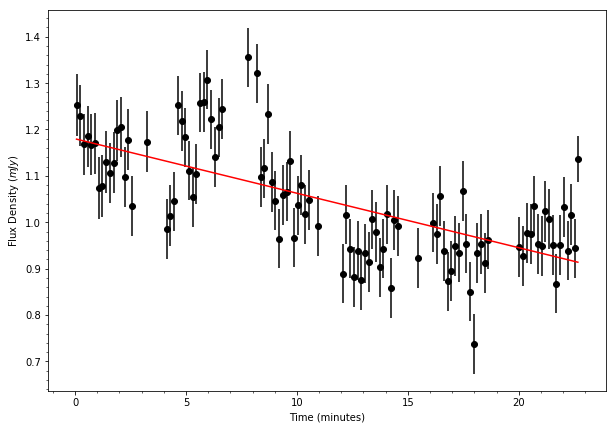

In [8]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e18_linearModel.png')
plt.show()

In [9]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.01099544,  1.17064992],
        [-0.01098597,  1.17906213],
        [-0.01118305,  1.15298567],
        [-0.00965825,  1.15441099],
        [-0.01045144,  1.1636003 ],
        [-0.01014943,  1.15365698],
        [-0.01165042,  1.18133394],
        [-0.01121694,  1.18586968],
        [-0.01159182,  1.18338205],
        [-0.01255454,  1.18181817],
        [-0.01093351,  1.16535017],
        [-0.01230388,  1.1877085 ],
        [-0.01091194,  1.17659279],
        [-0.01070567,  1.17212656],
        [-0.01133531,  1.16927455],
        [-0.01211402,  1.18532145],
        [-0.01095663,  1.16964816],
        [-0.01088455,  1.16451113],
        [-0.0126314 ,  1.19034986],
        [-0.01012478,  1.15862908],
        [-0.01089172,  1.17088657],
        [-0.0114975 ,  1.17270641],
        [-0.01126863,  1.17143752],
        [-0.01325511,  1.19719652],
        [-0.00995191,  1.15416887],
        [-0.01318012,  1.19349416],
        [-0.01126494,  1.1772834 ],
        [-0.0112505 ,  1.165

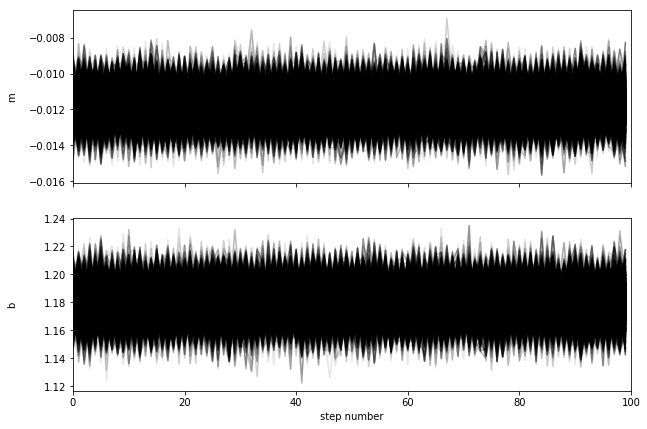

In [10]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e18_linearTrace.png')
plt.show()

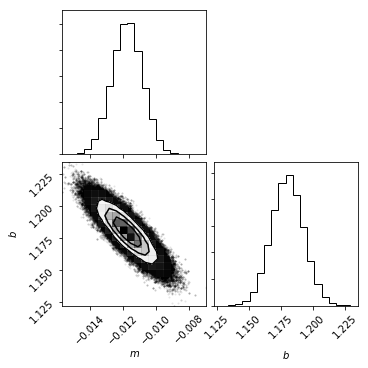

In [11]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e18_linearCorner.png')
plt.show()

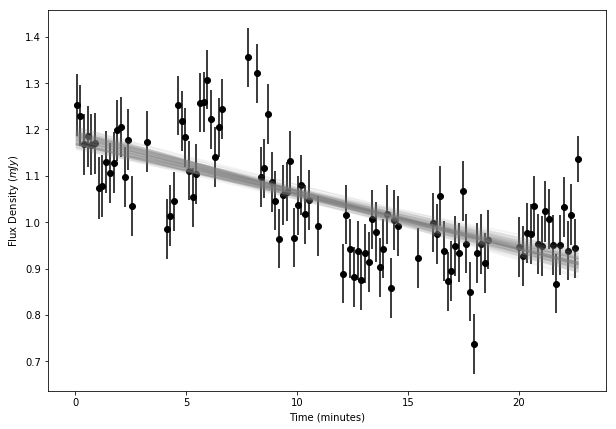

In [12]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e18_500mcmc_data.png')
plt.show()

In [13]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

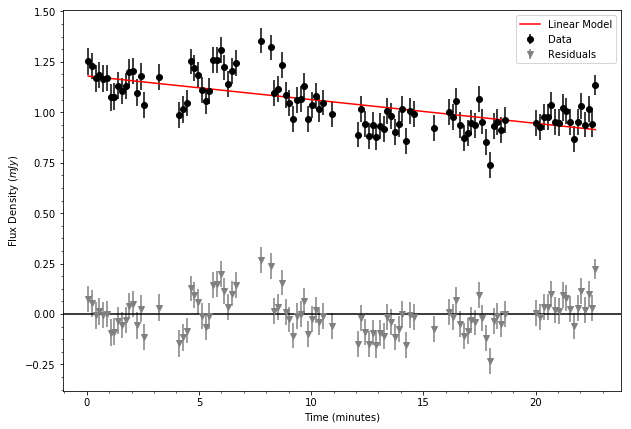

In [14]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,7))
plt.errorbar(x,y,yerr=yerr,color='black',fmt='o',linestyle='None',label='Data')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',fmt='v',linestyle='None',label='Residuals')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e18_linearModel_fit.png')
plt.show()

In [15]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(y)-2)

2.0841024588874846

## Looking at logistic function

In [27]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -2.5 < l < 1 and -3 < k < 10 and 5 < x0 < 15 and 1.0 < y0 < 1.5:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [28]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

-0.2083796366053094 1.7427530358113539 9.643667918042587 1.1648921044413252


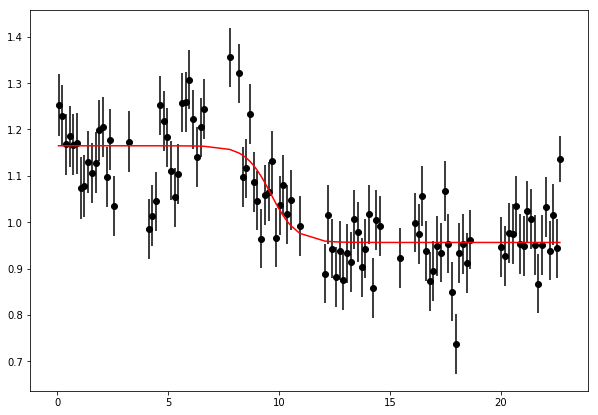

In [29]:
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,logModel([l_ml,k_ml,x0_ml,y0_ml],x),color='red')
plt.show()

In [30]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[-0.19943822,  1.7212222 ,  9.99421624,  1.16213221],
        [-0.19220795,  1.88694458,  9.62760472,  1.15975148],
        [-0.20103451,  2.21249371,  9.49460231,  1.16174075],
        [-0.23248512,  1.06030453,  9.40474083,  1.18003082],
        [-0.20193354,  2.22739864,  9.4245329 ,  1.16308764],
        [-0.2154857 ,  2.65322615,  9.20643665,  1.16895181],
        [-0.19494444,  3.59013905,  9.45581002,  1.15950009],
        [-0.2013401 ,  1.36609498,  9.62641042,  1.16336992],
        [-0.20317144,  2.11329857,  9.72287439,  1.16083719],
        [-0.2089035 ,  1.74900615,  9.65827225,  1.16861324],
        [-0.18170666,  1.95193314,  9.64809226,  1.15593888],
        [-0.215909  ,  1.33738438, 10.47524895,  1.16037133],
        [-0.19928891,  2.67423066, 10.24431217,  1.15191409],
        [-0.18939462,  5.31608721,  9.13480007,  1.16051739],
        [-0.18312236,  1.33009264,  9.86670805,  1.15116184],
        [-0.19742122,  2.54733114, 10.35799775,  1.15548349],
        

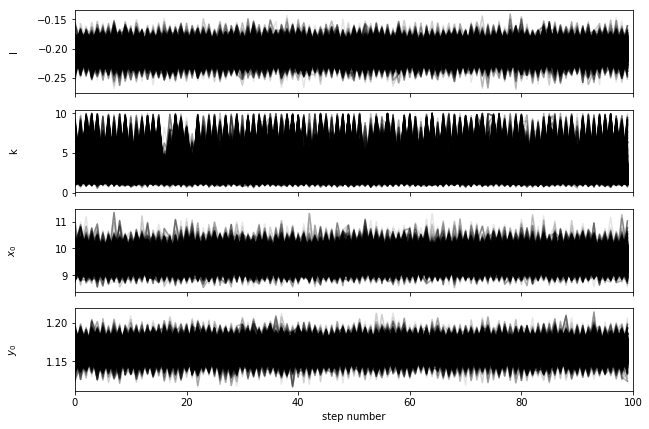

In [31]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('1314e18_Trace.png')
plt.show()

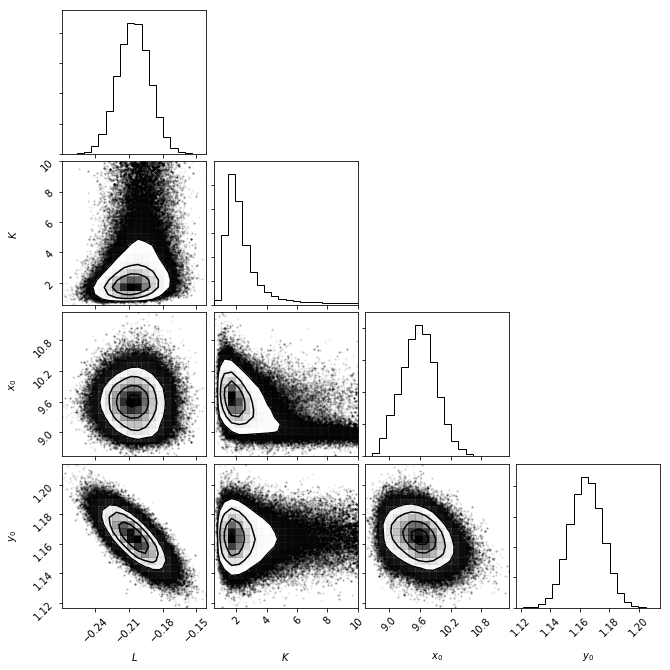

In [32]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/e18_logCorner.png')
plt.show()

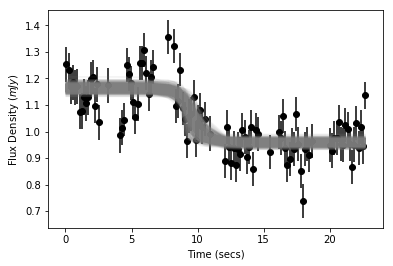

In [33]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
#plt.savefig('plots/500mcmc_log.png')
plt.show()

In [34]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

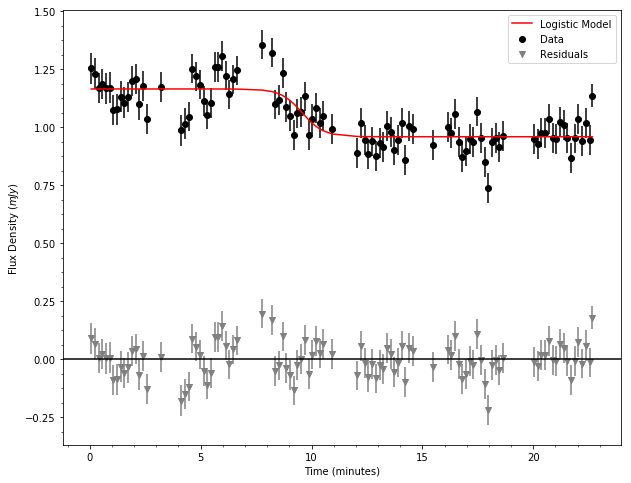

In [35]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(10,8))
binPlot(Type='minutes')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/e18_logModel.png')
plt.show()

In [37]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(y)-4)

1.4211055893090874

In [23]:
rr = pd.read_table('1314/2M1314e18-RR.dat')
ll = pd.read_table('1314/2M1314e18-LL.dat')

rr = binning(rr,10,2)
ll = binning(ll,10,2)
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

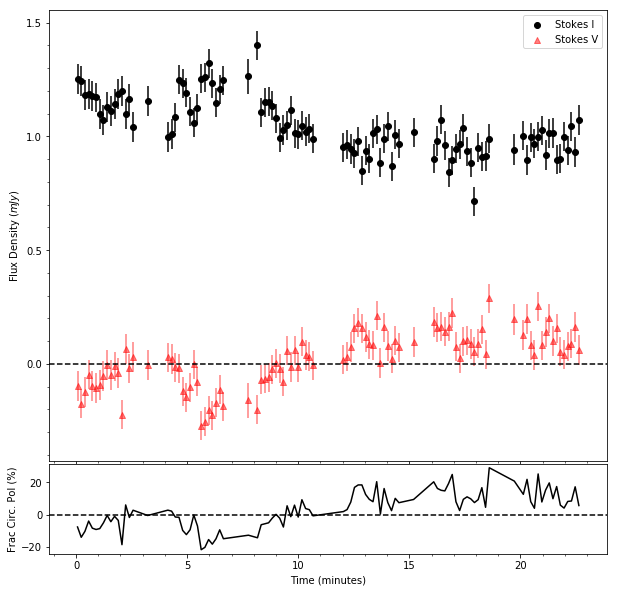

In [38]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='dashed')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.show()

In [39]:
high = pd.read_table('1314/2M1314e18-7GHz.dat')
low = pd.read_table('1314/2M1314e18-5GHz.dat')

high = high[high['nsamp']>3000]
low = low[low['nsamp']>3000]

high = binning(high,10,2)
low = binning(low,10,2)


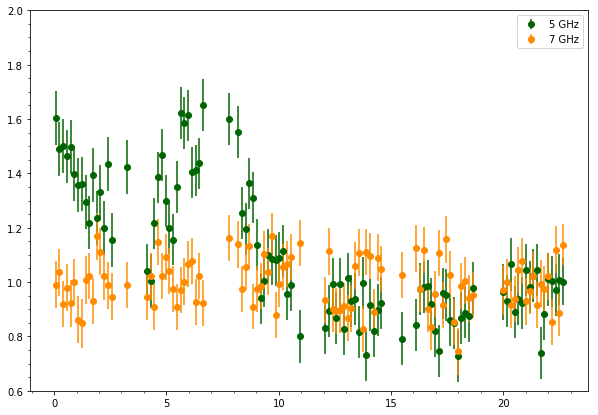

In [43]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',linestyle='None',color='darkgreen',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='o',linestyle='None',color='darkorange',label='7 GHz')
plt.minorticks_on()
plt.legend(loc='best')
plt.ylim(0.6,2.0)
plt.show()